# TempEst-NEXT Validation Suite

This Notebook provides a standard suite of model tests for TempEst-NEXT.  This serves two purposes:

1. Reproducibility of research.  This notebook is used to generate final manuscript figures relating to model performance. The notebook itself is provided with the published model and dataset, allowing exact reproducibility (and easy modification) of the analysis.
2. Efficient, consistent testing.  After modifying the model, running this notebook is a quick way to make sure everything still works and to assess performance impacts.

For validation, we use two pre-retrieved datasets as well as some automatic retrieval of new data.  The two pre-retrieved datasets are a "development" set of ~900 USGS gages (nominally 1,000; 900ish with overlapping data coverage) and a "test" set of 331 (nominal 400) USGS gages paired with daymet meteorology, 3DEP topography, NLCD land cover, etc.  The development set was used for model development and tuning, while the test set is reserved for final validation (i.e., here).  Test-set validations have been run during the development process, but are never used to directly inform model design.

The test suite also illustrates model runtime.

Some cells were used for initial data preparation, but do not need to be rerun.  These have been set to "raw" rather than Python, so simply running the entire Notebook will run all tests but nothing extraneous.

## Dependencies

To run the entire Notebook, requirements are:

- Python dependencies: TempEst-NEXT, matplotlib, and seaborn.  TempEst-NEXT is available (under that name) on the Python Package Index, so `pip install TempEst-NEXT`.  This will also install, as a dependency, TempEst-NEWT, the calibrated version of the model.
- A directory (specify location in `bp=` in the first cell) containing `DevData.csv`, `TestData.csv`, `DevDataHRRR3.csv`, and `TestDataHRRR3.csv`.  These should be provided with the notebook.  It should also contain a `results` subdirectory.
- In the same directory as the notebook:
    - An `ecoregions` directory, containing `NA_CEC_Eco_Level1.shp` (EPA Level I Ecoregions).
    - A `val_figures` directory

The preprocessing chunks have additional requirements, but are only used to generate the above data files and so don't need to be run.  They are set to `raw`, not `code`, so if the entire notebook is run they will not be executed.

Running the Notebook will reproduce all manuscript performance data and figures, except those relating to "true" forecasting (as opposed to reforecasting).  This is because performance evaluation for "true" forecasting requires separate steps to be run days apart and therefore can't be fully automated in a single run, though simply generating the forecast is automatic.

## Assessed Model Characteristics

The goal is to assess several model performance characteristics.  Forecasting is used for a handful of tests, but most analysis focuses on hindcasting for computational convenience.  It is assumed that any performance discrepancies in forecasting vs hindcasting would be apparent in the tests that cover both, and thus that not every analysis needs to test forecasting.

In this notebook, forecasting is primarily tested by using archived weather forecasts to predict what the forecast would have been for time periods where observations are available, which is necessary for automatic testing.  There is code to run a "real" forecast, but this cannot be automatically evaluated because observations are not available, so the user is left to go back and check once observations are available.

1. Calibrated model hindcasting and forecasting performance, using TempEst-NEWT like a typical single-watershed model
2. General ungaged hindcasting and forecasting performance
3. Ungaged-region hindcasting performance
4. Ungaged-elevation hindcasting performance
5. Ungaged-time-period hindcasting performance
6. Disturbance hindcasting performance?  TBD
7. Small-stream hindcasting performance?  TBD

## Tests

The following tests are used to assess the above performance characteristics.  Forecast tests cover just 2022, since HRRR retrieval is slow.

- Calibrated testing: train a model on the first 70% of observations for each stream, then evaluate performance for predicting the last 30%.  This uses the full dataset.
  - Use meteorology estimates (daymet) for training and testing: hindcast test.  Because the model architecture does not actually use "today's" weather (up through yesterday only), this is also a 24-hour forecast test.
  - Use weather forecast archives (HRRR, GFS/GEFS) for training and testing: forecast test.  Test forecast period of 2 days.
- Gagewise cross-validation: partition development dataset gages into *k* equal sets.  Train a model on all partitions but one, and evaluate performance for predicting the excluded partition.  This tests general ungaged performance, not accounting for any potential impact of having used the same dataset for model tuning.  Hindcasting (met estimate) only.  This uses the development dataset to show whether model tuning introduced any performance discrepancies (compared to test set validation).
- Test set validation: train a model on the development set, and evaluate performance for predicting the test set.  This tests general ungaged performance for a fully-independent dataset.
  - Meteorology estimates (hindcast)
  - Weather forecast archives (forecast) for 2-day (tomorrow) forecasts.  This has to be done with HRRR, since GFS doesn't have as readily-available long-term archives.
    - Trained on estimates/test on forecasts (forecast with heterogeneous data).
    - Trained on forecasts (homogeneous).
- Extrapolation hindcasting tests: partition the combined development and testing sets along some characteristic of interest, and use a model trained on one group to predict the other group.  This tests the ability of TempEst-NEXT to extrapolate in terms of specific characteristics.  All hindcasting.
  - Regional: partition the CONUS into contiguous regions and run leave-one-out cross-validation over the regions.
  - Elevation: train a model on the lower elevations and predict higher elevations.  Partial dependency plots and previous research suggest there is a major shift in watershed dynamics around 2300 m, and it is difficult to extrapolate past that barrier.
  - Time (walk-forward validation): train a model up to a given year, then predict the next year.  This tests whether the model can extrapolate forward in time.
- Regime-shift hindcasting: identify a set of watersheds for which the observed thermal regime has shifted significantly.  Train the model on everything else, then try to predict the disturbed watersheds and see how the model performs.  This assesses whether TempEst-NEXT is capable of capturing regime shifts.
- Small-stream hindcasting: if possible, use the model to predict temperatures at very small (e.g., first-order headwaters, centimeters to a few meters wide) streams where some observations are available, just to see if it works there.
- True forecasting: run TempEst-NEXT with a 1-16 day lead time in real time (HRRR and GFS), then come back and check the performance.  This needs to be rerun many times, preferably over multiple seasons, to be meaningful.


A full run takes about 3 hours.

# Data Preparation

In [1]:
import NEXT
from NEXT import wforecast
import NEWT
from rtseason import ThreeSine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import os
import dataretrieval.nwis as nwis
import geopandas as gpd
import matplotlib.animation as anim
import shapely
import scipy
from sklearn.ensemble import RandomForestClassifier
from scores.probability import brier_score_for_ensemble
import xarray as xr
from math import floor, ceil
warnings.catch_warnings(action="ignore")
sns.set_context("paper")
bp = "/scratch/dphilippus/notebooks/next_validation/"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


Use the `variant` options below to indicate the use of a different model implementation, so that all validations are rerun and results saved separately.  `coef_variant` refers to coefficient estimation and `newt_variant` to NEWT model design.

In [35]:
coef_variant = "_fd2pca" # current reference: FWPCA, 2PC
newt_variant = "_reference"
rerun = False

There are some major outliers that are either erroneous (negative temperatures) or wildly unrepresentative (hot springs) that we remove to produce realistic performance estimates.

In [3]:
datafiles = [bp + x + ".csv" for x in ["DevDataBuffers", "TestDataBuffers", "DevDataHRRR3", "TestDataHRRR3"]]

In [4]:
dev_data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"]).drop(columns=["swe", "tmin"]).dropna()
dev_data = dev_data[(dev_data["temperature"] > -0.5) & (dev_data["temperature"] < 40)]
test_data = pd.read_csv(bp + "TestDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"]).dropna()
test_data["day"] = test_data["date"].dt.day_of_year
all_data = pd.concat([dev_data, test_data]).drop(columns=["asp_north", "asp_east", "id_type", "unknown", "elev_std", "frozen", "cold_prcp"])
test_data_hrrr = pd.read_csv(bp + "TestDataHRRR3.csv", dtype={"id": "str"}, parse_dates=["date"]).merge(test_data[["id", "date", "canopy", "flowdir"]], on=["id", "date"], how="left")
dev_data_hrrr = pd.read_csv(bp + "DevDataHRRR3.csv", dtype={"id": "str"}, parse_dates=["date"]).merge(dev_data[["id", "date", "canopy", "flowdir"]], on=["id", "date"], how="left")
all_data_hrrr = pd.concat([test_data_hrrr, dev_data_hrrr]).drop(columns=["elev_std", "asp_north", "asp_east"])

### Forecast Archive Retrieval (does not need to be run)

A one-month run takes 0.02 hours, so 72 months should be about 1.5 hours, for a total of ~500 core-hours for the test set.  Needs to be run distributed.

### Data Preprocessing (does not need to be run)

# Calibrated Tests

Full dataset.

In [5]:
def cut_dev(gid, data, start=None):
    idd = data[data["id"] == gid]
    if idd["temperature"].mean() > 35 or idd["temperature"].mean() < 0:
        return (None, None)  # bad data or major outlier
    if start is None:
        cut = round(len(idd) * 0.7)
        if cut >= 365:
            return (idd.iloc[cut:], idd["date"].iloc[cut+1])
        else:
            return (None, None)  # dataset too small
    else:
        return idd[idd["date"] >= start]

def cal_val(gid, data, test_data = None, cal_fn = cut_dev, val_fn = cut_dev):
    (train, cutoff) = cal_fn(gid, data)
    if test_data is None:
        test_data = data
    # try:
    if cutoff is not None:
        test = cal_fn(gid, data, cutoff)
        model = NEWT.Watershed.from_data(train)
        if model is not None:
            return model.run_series(test)
    # except Exception as e:
    #     warnings.warn(str(e))

## Hindcast

In my last test, 919 watersheds took 26 minutes to train and predict, for about 2 seconds per watershed.

With GAM-sensitivity, 1225 watersheds took 42 minutes to train and predict, still at ~2 seconds each.

With full-series runs and GAM-sensitivity, 1225 watersheds took 10 minutes to train and predict, for ~0.5 seconds each.

In [6]:
file = bp + f"results/calibrated_hindcast{newt_variant}.csv"
if not rerun and os.path.exists(file):
    preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    # with warnings.catch_warnings(action="ignore"):
    preds = pd.concat([cal_val(x, all_data) for x in all_data["id"].unique()])
    runtime = (time.time() - start) / 60
    count = len(preds["id"].unique())
    print(f"Trained and ran {count} watershed models in {runtime:.1f} minutes.")
    preds.to_csv(file, index=False)

Overall performance summary below.  Note that stationarity, in particular, does absurdly well as a comparison point (same temperature today as yesterday).  As far as I'm aware, this comparison has not been run for most previous models.  It would be interesting to see how much of a lag is required for NEWT to outperform stationarity.  This does suggest that, if you have observations, "same as yesterday" is probably a better bet than most non-data-assimilating models.

Interestingly, when a massive outlier that was predicting anomalies in the thousands of degrees is removed, global performance is very similar to gagewise performance.  Note that huge anomaly sensitivity isn't representative of any real use case, since in a calibrated model that would be corrected for and the (smoothed) coefficient estimation model won't predict such high sensitivity.  (If it did happen, it would be fairly obvious that ~3000 C is not a reasonable estimate.)

Using GAM-anomaly reduced median and global RMSE by about 0.1 C to 1.4 C (for both).  Anomaly NSE increased to 0.61 (0.92 globally), median R2 to 0.95, and global R2 to 0.97.  Overall NSE increased to 0.95 and 0.97.

In [7]:
with warnings.catch_warnings(action="ignore"):
    print(preds.groupby("id").apply(NEWT.analysis.perf_summary).describe())

                R2         RMSE          NSE  StationaryNSE  ClimatologyNSE  \
count  1225.000000  1225.000000  1225.000000    1225.000000     1225.000000   
mean      0.937241     1.399565     0.937215       0.977105        0.952473   
std       0.067866     0.418337     0.067968       0.017552        0.048964   
min       0.373559     0.105841     0.368970       0.816626        0.287647   
25%       0.933140     1.159317     0.933120       0.969819        0.937219   
50%       0.952737     1.385609     0.952736       0.980610        0.959158   
75%       0.967702     1.606944     0.967699       0.989068        0.978736   
max       0.992155     6.878842     0.992146       0.999378        1.000000   

        AnomalyNSE        Pbias         Bias      MaxMiss  
count  1089.000000  1225.000000  1225.000000  1225.000000  
mean      0.557053     0.016667     0.001476     1.231975  
std       0.199223     0.099347     0.007731     0.756906  
min      -0.346025    -0.276735    -0.034257    

In [8]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.967017,1.417573,0.967016,0.984059,0.604775,0.921333,0.006473,0.000865,1.457304


## Forecast

Trained and tested with HRRR.  Note this limits the data coverage (~2018-22).  Since the POR is shorter and there are fewer applicable watersheds, this takes 4 minutes.

Performance here is very similar, though a little worse; at calibrated sites, the seasonal skill dominates and the slight penalty to anomaly performance has little effect.  Median/global R2 0.95/0.96, RMSE 1.4/1.5 C, NSE 0.95/0.96, pbias 0.007%/0.01%, max-miss 1.3/1.1 C.

In [9]:
file = bp + f"results/calibrated_reforecast{newt_variant}.csv"
if not rerun and os.path.exists(file):
    preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    # with warnings.catch_warnings(action="ignore"):
    preds = pd.concat([cal_val(x, all_data_hrrr) for x in all_data_hrrr["id"].unique()])
    runtime = (time.time() - start) / 60
    count = len(preds["id"].unique())
    print(f"Trained and ran {count} watershed models in {runtime:.1f} minutes.")
    preds.to_csv(file, index=False)

/tmp/ipykernel_2559073/2953505268.py:3: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  preds = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])


In [10]:
with warnings.catch_warnings(action="ignore"):
    print(preds.groupby("id").apply(NEWT.analysis.perf_summary).describe())

                R2         RMSE          NSE  StationaryNSE  ClimatologyNSE  \
count  1027.000000  1027.000000  1027.000000    1027.000000     1027.000000   
mean      0.934991     1.449691     0.934943       0.977017        0.977886   
std       0.049302     0.443302     0.049459       0.018236        0.020507   
min       0.475008     0.111066     0.474925       0.824091        0.781970   
25%       0.920180     1.122598     0.920176       0.969221        0.968671   
50%       0.945416     1.431002     0.945409       0.980629        0.981338   
75%       0.964443     1.801454     0.964428       0.989583        0.991856   
max       0.992155     2.779918     0.992146       0.999835        1.000000   

       AnomalyNSE        Pbias         Bias      MaxMiss  
count  866.000000  1027.000000  1027.000000  1027.000000  
mean     0.515597     0.025201     0.002233     1.368869  
std      1.056598     0.127472     0.009033     0.700930  
min    -29.953391    -0.231682    -0.025038     0.03

In [11]:
NEWT.analysis.perf_summary(preds)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.961892,1.527218,0.961889,0.98268,0.615097,0.912682,0.010203,0.001327,1.148731


# Gagewise Cross-Validation

Runtime: 1.9 hours for 930 sites and ~3M observations.  That makes >1.5 years/second, assuming most of the time is prediction, and a total of 7.5 seconds per site.

With no modification engines, it is 0.43 hours, making 1.7 seconds/site and >5 years/second.

With full-series runs and GAM-sensitivity, training still takes a few minutes, but prediction is almost instantaneous.  It still takes 0.4 hours total, suggesting that runtime is dominated by model training.  Oddly, performance is not improved by the GAM-sensitivity.

In [36]:
# Modbuilder: data -> (ws -> prediction)
logfile = bp + "results/kfold_log.txt"
def make_modbuilder(use_clim, lookback):
    def next_modbuilder(data):
        nx = NEXT.NEXT.from_data(data)
        def prd(x):
            print("|", end="")
            # return nx.run(x, reset=True, use_climate=use_clim, climyears=lookback)
            try:
                # return nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt().coefs_to_df()
                return nx.run(x, reset=True, use_climate=use_clim, climyears=lookback)
                # mod = nx.make_newt(x, reset=True, use_climate=use_clim, climyears=lookback).get_newt()
                # mod.dynamic_engine = None
                # return mod.run_series(x)
            except KeyboardInterrupt as e:
                raise e
            except Exception as e:
                print("Error", end="")
                with open(logfile, "a") as lf:
                    lf.write(f"Error in gage {x["id"].iloc[0]} for use_clim={use_clim} and lookback={lookback}: {e}\n")
                return None
        return prd
    return next_modbuilder

In [37]:
clim = False
lookback = 10
timing = bp + "results/kfold_times.txt"
out = bp + f"results/kfold_pca{coef_variant}.csv"
with warnings.catch_warnings(action="ignore"):
    start = time.time()
    kfr = NEWT.analysis.kfold(dev_data, make_modbuilder(clim, lookback), output=out, redo=rerun)
    print(f"\nLookback: {lookback} : {(time.time() - start) / 3600: .2f} hours for {len(dev_data["id"].unique())} sites with {len(dev_data)} observations")

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
Lookback: 10 :  0.40 hours for 928 sites with 2986986 observations


In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = kfr.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,928.000000,928.000000,928.0,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000,928.000000
mean,40.024700,-93.773787,0.0,0.896549,2.353910,0.435458,0.976446,0.914497,0.324867,3.476782,0.247860,2.458117
std,4.522685,17.162228,0.0,0.123974,1.174512,5.100981,0.017759,0.066951,0.893613,13.320915,1.454117,1.807688
min,26.975000,-124.392987,0.0,0.002907,1.133431,-144.612320,0.858323,0.175511,-19.237903,-68.047446,-20.434782,0.127566
25%,37.730899,-109.882554,0.0,0.886501,1.770382,0.799884,0.969363,0.900950,0.257139,-2.536321,-0.361235,1.140953
50%,40.132276,-86.485407,0.0,0.934840,2.107657,0.901673,0.980235,0.928521,0.566978,2.342874,0.282187,2.068899
75%,42.986410,-79.563692,0.0,0.956424,2.581017,0.934439,0.988397,0.949401,0.682885,6.702354,0.835994,3.272154
max,48.998814,-67.803889,0.0,0.981669,21.178658,0.976021,0.999005,0.988499,0.830128,147.569744,6.554343,19.595129


FWPCA:

- All PCs: R2 0.94, RMSE 2.1, NSE 0.90, anomaly 0.49, maxmiss 2.4, spatial predictability 0.78 (0.62-0.87) and 0.73 (0.60-0.82).
- Five PCs: R2 0.94, RMSE 2.1, NSE 0.90, anomaly 0.56, maxmiss 2.0, spatial 0.78 (0.62-0.86) and 0.73 (0.61-0.82).
- Two PCs: R2 0.93, RMSE 2.1, NSE 0.9, anomaly 0.56, maxmiss 2.0, spatial 0.79 (0.63-0.86) and 0.73 (0.61-0.81).
- Three PCs, fixed dates: R2 0.94, RMSE 2.1, NSE 0.9, anomaly 0.57, maxmiss 2.0, spatial 0.78 (0.62-0.86) and 0.72 (0.61-0.82).
- Four PCs, fixed dates: R2 0.94, RMSE 2.1, NSE 0.90, anomaly 0.57, maxmiss 2.1, spatial 0.79 (0.62-0.86) and 0.73 (0.61-0.82).
- Six PCs, fixed dates: R2 0.94, RMSE 2.1, NSE 0.90, anomaly 0.56, maxmiss 2.1, spatial 0.79 (0.62-0.86) and 0.73 (0.61-0.83).
- Two PCs, restricted variables: R2 0.93, RMSE 2.2, NSE 0.90, anomaly 0.56, maxmiss 2.1, spatial 0.76 (0.62-0.83) and 0.71 (0.60-0.79). Other performance is *atrocious*.
- Two PCs, fixed dates: R2 0.93, RMSE 2.1, NSE 0.90, anomaly 0.57, maxmiss 2.1, spatial 0.78 (0.62-0.86) and 0.73 (0.61-0.81).

## Predictability Analysis

Analyze spatiotemporal predictability in cross-validation.

### Daily Spatial and Spatiotemporal

Predictability of DOY-mean for each DOY.

Predictability of daily/yearly timeseries for each DOY.

In [ ]:
doymean = kfr.groupby(["id", "day"])[["temperature", "temp.mod"]].mean()

In [ ]:
r2s = doymean.groupby("day").apply(lambda x: x["temperature"].corr(x["temp.mod"])**2)

Spatial predictability is a median of 77%, ranging from 61-86%. So why the poor skill for coefficients? Maybe, while variance is more widely distributed, the *effect* is dominated by just a few...

In [ ]:
r2s.describe()

count    365.000000
mean       0.773529
std        0.057067
min        0.618392
25%        0.748878
50%        0.784681
75%        0.817763
max        0.859917
dtype: float64

In [ ]:
r2st = kfr.groupby("day").apply(lambda x: x["temperature"].corr(x["temp.mod"])**2, include_groups=False)

Spatiotemporal predictability is a little worse, ranging from 60-82% with a median of 72%.

In [ ]:
r2st.describe()

count    365.000000
mean       0.726679
std        0.051259
min        0.607642
25%        0.697114
50%        0.725286
75%        0.771999
max        0.810926
dtype: float64

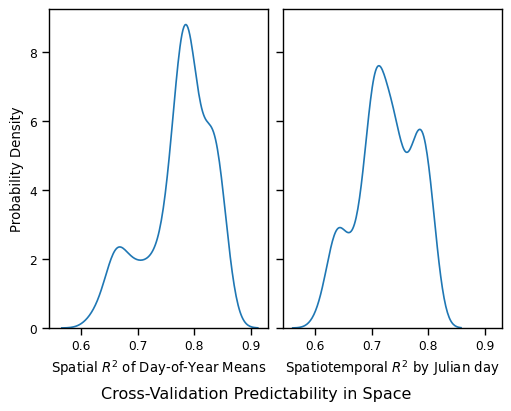

In [ ]:
(fig, [ax1, ax2]) = plt.subplots(1, 2, figsize=(5, 4), layout="compressed", sharex=True, sharey=True)
sns.kdeplot(r2s, ax=ax1)
sns.kdeplot(r2st, ax=ax2)
ax2.set_ylabel(None)
ax1.set_ylabel("Probability Density")
ax1.set_xlabel("Spatial $R^2$ of Day-of-Year Means")
ax2.set_xlabel("Spatiotemporal $R^2$ by Julian day")
fig.supxlabel("Cross-Validation Predictability in Space")
plt.savefig("val_figures/spatial_skill_kde.png", dpi=1200)

### Seasonal Spatial

Predictability of each 3S coefficient.

In [ ]:
def get_ssn(day, temps):
    data = pd.DataFrame({"day": day, "temperature": temps})
    try:
        return ThreeSine.from_data(data, warn=False).to_df()
    except:
        return None  # failed fit
ssn_obs = kfr.groupby("id").apply(lambda x: get_ssn(x["day"], x["temperature"]), include_groups=False)
ssn_mod = kfr.groupby("id").apply(lambda x: get_ssn(x["day"], x["temp.mod"]), include_groups=False).rename(columns=lambda x: x + "_mod")

The 2-PC model does underpredict both the SpringSummer and FallWinter coefficients, but still outperforms the full-PC model even for high elevations, evidently due to lower overall noise. The problem here is crappy predictability for snow components, evidently.

In [ ]:
ssn_obs.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
count,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,0.0,921.000000
mean,12.740611,8.882271,326.754615,66.920738,154.072747,217.706840,0.739331,1.398586,NaN,0.817305
std,3.993522,2.723334,15.606734,32.471663,21.644261,17.322166,0.955159,0.920420,NaN,0.338894
min,3.085846,0.182583,300.000000,1.000000,120.000000,200.000000,-2.585014,-2.453322,NaN,0.066742
25%,9.907242,7.209934,317.000000,33.000000,135.000000,200.000000,0.062890,0.828810,NaN,0.593958
50%,12.520833,9.357408,327.000000,84.000000,156.000000,212.000000,0.471416,1.409035,NaN,0.750507
75%,14.876002,10.884484,333.000000,90.000000,177.000000,238.000000,1.199086,1.924694,NaN,0.989444
max,30.100749,15.907383,365.000000,110.000000,180.000000,240.000000,4.922727,4.801733,NaN,2.884704


In [ ]:
ssn_mod.describe()

,Intercept_mod,Amplitude_mod,FallDay_mod,WinterDay_mod,SpringDay_mod,SummerDay_mod,SpringSummer_mod,FallWinter_mod,R2_mod,RMSE_mod
count,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,921.000000,0.0,921.000000
mean,13.011813,8.530998,360.178067,76.804560,140.442997,211.179153,0.097798,0.807718,NaN,0.176033
std,3.784163,2.002127,12.881348,11.581578,12.167011,7.407652,0.071784,0.262930,NaN,0.055785
min,3.200194,2.533859,300.000000,27.000000,120.000000,200.000000,-0.031870,-1.255839,NaN,0.033977
25%,10.283399,7.251597,363.000000,71.000000,132.000000,208.000000,0.057591,0.672477,NaN,0.142823
50%,12.707314,9.004596,365.000000,77.000000,140.000000,209.000000,0.085481,0.866619,NaN,0.178249
75%,14.832638,9.870805,365.000000,84.000000,147.000000,212.000000,0.112439,0.978074,NaN,0.207623
max,25.330356,14.054213,365.000000,110.000000,180.000000,240.000000,0.663756,1.633597,NaN,0.472882


Here, we see more expected behavior. Spatial skill is highly variable, ranging from just 3.4% (SummerDay) to 86% (Intercept). It's just that the low-skill coefficients don't contribute much; Intercept (86%) and Amplitude (56%) must dominate variability. We should also look at the NSE to see which ones are actually worth predicting.

With the two-PCA, skill ranges from 1.9% (SummerDay) to 88% (Intercept). Mean and median are, unsurprisingly, lower, at 26% and 11%.  Three-PCA does substantially improve skill for some of the seasonal anomaly terms. Adding a fourth PC brings a further slight improvement to anomaly magnitude skill. Six-PCA makes further marginal improvements to SpringSummer and FallWinter, at the expense of SpringDay and SummerDay.  The original setup has far higher skill for FallWinter, in particular, and a little better in SpringSummer, despite somewhat worse overall performance.

In [ ]:
fits = pd.Series({
    nm: ssn_obs[nm].corr(ssn_mod[nm + "_mod"])**2  # hand-verified they are all positive
    for nm in ssn_obs.columns
    if not nm in ["R2", "RMSE"]
})
fits

Intercept       0.876725
Amplitude       0.578527
FallDay         0.107853
WinterDay       0.223968
SpringDay       0.154962
SummerDay       0.027088
SpringSummer    0.024264
FallWinter      0.057499
dtype: float64

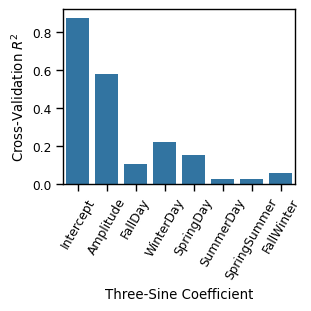

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), layout="compressed")
sns.barplot(fits, ax=ax)
ax.set_xlabel("Three-Sine Coefficient")
ax.set_ylabel("Cross-Validation $R^2$")
plt.xticks(rotation=60)
plt.savefig("val_figures/skill_3s.png", dpi=1200)

In [ ]:
def nse(sim, obs):
    mse = np.mean((sim - obs)**2)
    ovar = obs.var()
    return 1 - mse/ovar
nses = pd.Series({
    nm: nse(ssn_mod[nm + "_mod"], ssn_obs[nm])
    for nm in ssn_obs.columns
    if not nm in ["R2", "RMSE"]
})
nses

Intercept       0.872120
Amplitude       0.561701
FallDay        -4.724352
WinterDay       0.118584
SpringDay      -0.269020
SummerDay      -0.182987
SpringSummer   -0.432283
FallWinter     -0.355687
dtype: float64

## Plots

In [ ]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]

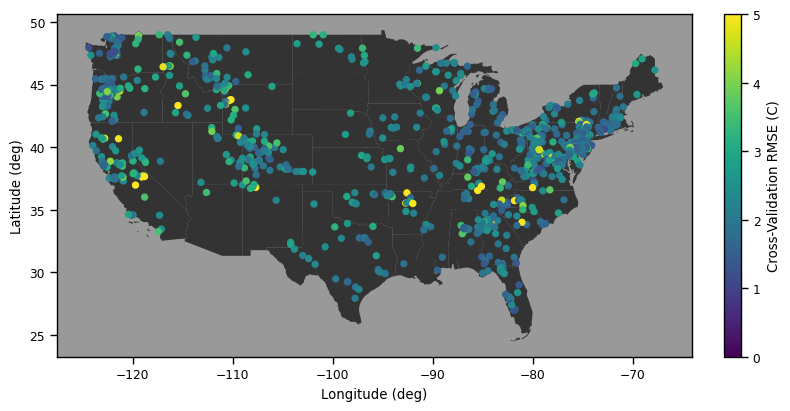

In [ ]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="RMSE", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation RMSE (C)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_rmse.png", dpi=1000)

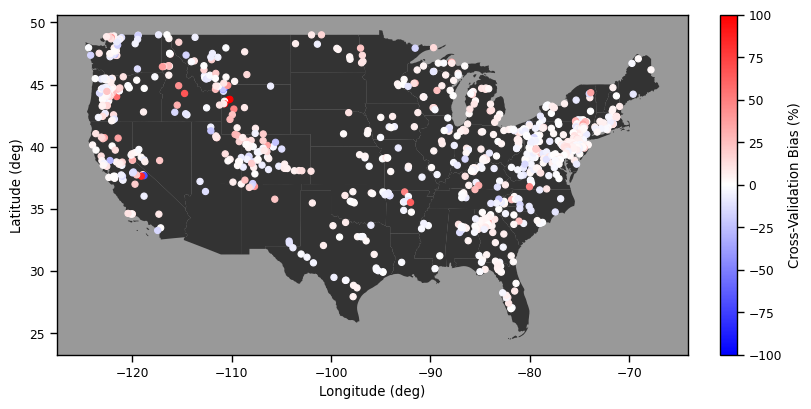

In [ ]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#999")
states.plot(ax=ax, color="#333")
perf.plot.scatter(x="lon", y="lat", c="Pbias", ax=ax, colormap="bwr", vmin=-100, vmax=100)
cb = ax.collections[1].colorbar
cb.set_label("Cross-Validation Bias (%)")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_bias.png", dpi=1000)

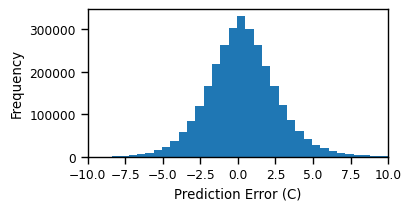

In [ ]:
fig = plt.figure(figsize=(4, 2), layout="compressed")
ax = plt.axes()
kfr["error"] = kfr["temp.mod"] - kfr["temperature"]
kfr["error"].plot.hist(bins=100, ax=ax)
ax.set_xlim(-10, 10)
ax.set_xlabel("Prediction Error (C)")
plt.savefig("val_figures/ErrorHist_xv.png", dpi=1000)

In [ ]:
ecos = gpd.read_file("ecoregions/NA_CEC_Eco_Level1.shp").to_crs(4326)

In [ ]:
def get_name(df):
    if len(df) > 0:
        return df.iloc[0]["NA_L1NAME"].title()
    else:
        return "NA"
perf_pts = gpd.GeoSeries([shapely.Point(x.lon, x.lat) for x in perf.itertuples()])
pt_ecos = pd.Series([get_name(ecos[ecos.contains(x)]) for x in perf_pts])

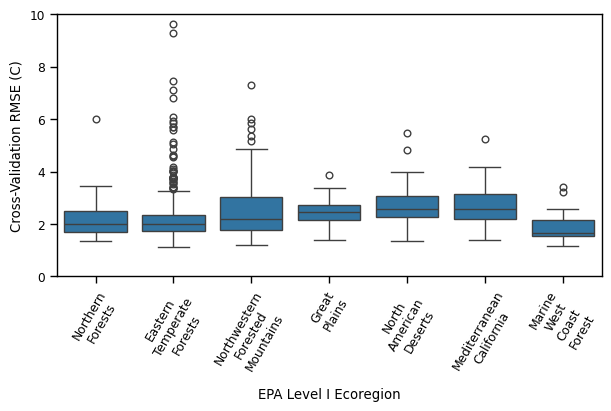

In [ ]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf[perf["ecoregion"] != "NA"], y="RMSE", x="ecoregion", ax=ax)
plt.xticks(rotation=60)
ax.set_ylim(0, 10)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation RMSE (C)")
plt.savefig("val_figures/EcoregionRMSEBox.png", dpi=1000)

In [ ]:
perf[perf["RMSE"] > 10]

,id,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss,ecoregion
562,06036940,44.732725,-110.713253,0,0.813566,14.971731,-11.209598,0.917760,0.824984,0.331512,-68.047446,-14.840156,15.149065,Northwestern\nForested\nMountains
730,10265150,37.668822,-118.817631,0,0.055390,21.178658,-18.836340,0.950897,0.175511,0.048770,-67.914093,-20.434782,19.595129,North\nAmerican\nDeserts


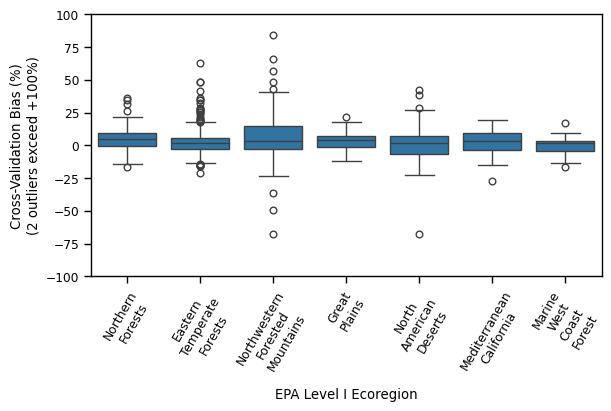

In [ ]:
fig = plt.figure(figsize=(6, 4), layout="compressed")
ax = plt.axes()
perf["ecoregion"] = [x.replace(" ", "\n") for x in pt_ecos]
sns.boxplot(perf[perf["ecoregion"] != "NA"], y="Pbias", x="ecoregion", ax=ax)
plt.xticks(rotation=60)
ax.set_ylim(-100, 100)
ax.set_xlabel("EPA Level I Ecoregion")
ax.set_ylabel("Cross-Validation Bias (%)\n(2 outliers exceed +100%)")
plt.savefig("val_figures/EcoregionBiasBox.png", dpi=1000)

# Test Set Validation

In [ ]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data)
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 137 seconds to train


In [ ]:
model.to_pickle("coefs.pickle")

## Hindcast

This (full timeseries for 750k rows/331 watersheds) took 22 minutes, 1300 seconds.  As before, that's about 1.5 years per second.  The next run took 1200 seconds.

With single-pass and GAM-sensitivity, it took 24 seconds, or 86 years per second.

In [ ]:
def predict(ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except:
        return None

In [ ]:
ppath = bp + f"results/TestSet_hindcast{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 15 seconds to predict


In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,320.000000,320.000000,320.0,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000,320.000000
mean,39.902969,-95.030326,0.0,0.885046,2.352602,0.136153,0.978241,0.913688,0.263918,1.882790,0.125554,2.380954
std,4.643460,17.260681,0.0,0.140114,0.978913,6.703961,0.019003,0.076455,1.020193,12.706337,1.160109,1.784952
min,28.332787,-124.357089,0.0,0.043240,1.198609,-108.632363,0.824755,0.339466,-10.634511,-37.995545,-3.831036,0.153949
25%,36.555978,-111.425710,0.0,0.873801,1.788887,0.800505,0.972066,0.898901,0.192248,-3.744696,-0.488670,1.066079
50%,40.175895,-87.479876,0.0,0.929345,2.130989,0.893188,0.981524,0.931081,0.532719,0.972614,0.121246,1.887901
75%,43.327292,-81.167361,0.0,0.954279,2.580587,0.928981,0.990598,0.949809,0.666471,5.331132,0.666405,3.291129
max,48.984601,-67.935278,0.0,0.982176,8.130387,0.979349,0.999155,0.996135,0.833396,126.033702,5.718362,11.128891


### Good/Bad Sites

This allows you to look at the best- and worst-performing test set sites on a map and cluster analysis and see if anything is going on.

In [ ]:
ranked = perf.sort_values("RMSE")
best = ranked.iloc[:100].assign(title = ["best" + str(ix) for ix in range(1,101)])
worst = ranked.iloc[-100:].assign(title = ["worst" + str(ix) for ix in range(100, 0, -1)])
midpt = int(len(ranked) / 2)
mid = ranked.iloc[(midpt-50):(midpt+50)].assign(title = ["middle" + str(ix) for ix in range(1, 101)])
comb = pd.concat([best, worst, mid])[["lat", "lon", "title"]]
comb["id"] = comb["title"]
pts = [shapely.Point(x.lon, x.lat) for x in comb.itertuples()]
comb = gpd.GeoDataFrame(data=comb, geometry=pts, crs=4326)
# comb.to_file("goodbadsites.json", driver='GeoJSON')

#### Quantifications

In [ ]:
best.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,40.084915,-92.791160,0.0,0.925921,1.640881,0.897688,0.974513,0.917423,0.494947,1.962853,0.231886,1.241680
std,4.690148,16.970058,0.0,0.055507,0.157414,0.087416,0.017734,0.038215,0.296224,4.388800,0.498996,0.703237
min,28.332787,-124.058144,0.0,0.704410,1.198609,0.516253,0.896933,0.796635,-0.485168,-9.346857,-0.986172,0.153949
25%,37.799164,-107.669376,0.0,0.899900,1.563292,0.876066,0.966503,0.890290,0.323194,-0.708903,-0.083425,0.777205
50%,41.070725,-84.497889,0.0,0.942182,1.675682,0.925434,0.977726,0.927001,0.618217,1.784128,0.237100,1.065449
75%,42.631206,-79.932861,0.0,0.965272,1.756528,0.955427,0.986934,0.946013,0.698201,4.551480,0.581616,1.527396
max,48.708143,-71.609509,0.0,0.982176,1.859068,0.979349,0.997463,0.980570,0.830767,13.527442,1.358141,3.512260


In [ ]:
worst.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,100.000000,100.000000,100.0,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,40.204054,-100.640207,0.0,0.799838,3.323819,-1.519878,0.979733,0.890465,-0.121584,3.031535,0.065019,3.771268
std,4.981845,17.297517,0.0,0.215138,1.227238,11.864674,0.024697,0.123301,1.564732,21.087618,1.821034,2.235469
min,29.952733,-124.357089,0.0,0.043240,2.469486,-108.632363,0.824755,0.339466,-10.634511,-37.995545,-3.831036,0.397159
25%,36.505349,-119.541493,0.0,0.782666,2.611067,0.446340,0.978079,0.897676,-0.201606,-8.571347,-1.084652,1.923144
50%,39.546614,-102.274576,0.0,0.874777,2.940863,0.790334,0.985924,0.930720,0.253195,-1.988374,-0.273395,3.587961
75%,44.538357,-84.543153,0.0,0.924695,3.416958,0.872299,0.991860,0.952431,0.544974,10.742564,1.160215,4.765694
max,48.984601,-67.935278,0.0,0.969222,8.130387,0.931941,0.999155,0.995276,0.829169,126.033702,5.718362,11.128891


#### Classification Analysis

We'll use scikit-learn's Random Forest ensemble, since that's both simple and flexible.  70/30 train/test.

In [ ]:
allbw = pd.DataFrame({"id": pd.concat([best["id"], mid["id"], worst["id"]]), "rank": ["best"] * 100 + ["mid"] * 100 + ["worst"] * 100}
                    ).merge(NEXT.coef_est.preprocess(test_data), on="id"
                           ).drop(columns=["level_1_x", "level_1_y", "date", "day"])
train = allbw.groupby("rank").sample(n=70)
test = allbw.loc[-allbw["id"].isin(train["id"]),:]
getX = lambda x: x.drop(columns=["id", "rank"])
getY = lambda x: x["rank"]
# test = test.loc[test["rank"] != "mid",:]
# train = train.loc[train["rank"] != "mid", :]

In [ ]:
rf = RandomForestClassifier().fit(getX(train), getY(train))
rf.score(getX(train), getY(train))

1.0

In [ ]:
rf.score(getX(test), getY(test))

0.4111111111111111

Accuracy is 38% (correctly classified).  Proportion correctly classified by chance should be 1/3. This accuracy is worse than it was with the all-PC model, so dropping PCs increases the randomness of performance.

## Reforecast (heterogeneous)

Note that the time period is not the same as the hindcast test, due to limited HRRR archive coverage.

Data retrieval uses the *earliest* HRRR run covering a given date (i.e., 48 hours out), so this is a 2-day forecast lead time (it uses this morning's forecast - where today's max temperature is itself one day of forecast - to predict tomorrow).

For comparison purposes here, the median R2 of pure climatology (i.e., fitted seasonality) is 0.90.  Stationarity probably does better than NEXT, but stationarity isn't actually available in an ungaged context - though, of course, neither is climatology!

RMSE did increase a fair bit, to 2.9 C.  That seems to be driven by an increase in bias (to 8%/1.0 C), which probably has to do with the heterogeneous training data.  (Next up: pull HRRR for the full dataset and do a homogeneous run.)  Still, the R2 is better than climatology at 0.92.  (See below: it's the heterogeneity.)  The PCA, GAM-sensitivity version did a bit better than the original here.

2-PC version has a much lower penalty here, with an RMSE of 2.6 C.

In [ ]:
def predict(ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except:
        return None

In [ ]:
ppath = bp + f"results/TestSet_reforecast{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data_hrrr.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 13 seconds to predict


In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,303.000000,303.000000,303.0,303.000000,303.000000,303.000000,303.000000,303.000000,298.000000,303.000000,303.000000,303.000000
mean,39.907014,-95.509951,0.0,0.855053,2.920947,-0.568777,0.978460,0.929910,-0.290289,7.044795,0.854660,2.427242
std,4.677083,17.366814,0.0,0.147556,1.238400,13.673416,0.020466,0.071562,1.845181,17.236846,1.740021,1.962737
min,28.332787,-124.357089,0.0,0.042645,1.410737,-229.473162,0.824468,0.335259,-17.577800,-71.152314,-4.872546,0.204718
25%,36.610189,-111.746329,0.0,0.840365,2.193229,0.659887,0.972174,0.920568,-0.367956,-0.982218,-0.118922,1.118606
50%,40.036652,-88.156111,0.0,0.890769,2.641204,0.825384,0.981786,0.945719,0.171246,6.243399,0.834719,1.784820
75%,43.349958,-81.273662,0.0,0.937289,3.280389,0.902182,0.991419,0.961289,0.458771,13.370443,1.767368,3.016597
max,48.984601,-67.935278,0.0,0.974867,13.313344,0.970844,0.999801,1.000000,0.863389,135.973181,10.423428,12.754943


## Reforecast (homogeneous)

Note that the time period is not the same as the hindcast test, due to limited HRRR archive coverage.

Data retrieval uses the *earliest* HRRR run covering a given date (i.e., 48 hours out), so this is a 2-day forecast lead time (it uses this morning's forecast - where today's max temperature is itself one day of forecast - to predict tomorrow).

For comparison purposes here, the median R2 of pure climatology (i.e., fitted seasonality) is 0.90.  Stationarity probably does better than NEXT, but stationarity isn't actually available in an ungaged context - though, of course, neither is climatology!

It does better with a homogeneous reforecast; RMSE decreases to 2.3 C.  R2 doesn't change.

In [ ]:
start = time.time()
with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(dev_data_hrrr.dropna())
runtime = int(time.time() - start)
print(f"Took {runtime} seconds to train")

Took 84 seconds to train


In [ ]:
model.to_pickle("coefs_hrrr.pickle")

In [ ]:
def predict(ws):
    print("|", end="")
    return model.run(ws, reset=True)

In [ ]:
ppath = bp + f"results/TestSet_reforecast_homog{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data_hrrr.groupby("id").apply(predict, include_groups=False).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 13 seconds to predict


In [ ]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(["id", "lat", "lon"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()
perf.describe()

,lat,lon,level_3,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,303.000000,303.000000,303.0,303.000000,303.000000,303.000000,303.000000,303.000000,298.000000,303.000000,303.000000,303.000000
mean,39.907014,-95.509951,0.0,0.862607,2.563108,-0.209980,0.978460,0.929910,-0.136196,1.831025,0.088306,2.679908
std,4.677083,17.366814,0.0,0.152099,1.059681,11.036717,0.020466,0.071562,1.824396,12.850309,1.375987,1.909361
min,28.332787,-124.357089,0.0,0.001802,1.399210,-185.749601,0.824468,0.335259,-22.100665,-35.881880,-4.650454,0.338635
25%,36.610189,-111.746329,0.0,0.846539,1.998246,0.765388,0.972174,0.920568,-0.098526,-3.784327,-0.533092,1.255564
50%,40.036652,-88.156111,0.0,0.908020,2.317783,0.859148,0.981786,0.945719,0.281745,0.754013,0.081941,2.182710
75%,43.349958,-81.273662,0.0,0.944108,2.812985,0.920609,0.991419,0.961289,0.510383,6.020756,0.714517,3.540605
max,48.984601,-67.935278,0.0,0.976626,12.667612,0.969372,0.999801,1.000000,0.875563,99.043539,9.217739,11.141551


## Uncertainty

In [ ]:
def predict(ws, Nco=100, Nanom=10):
    print("|", end="")
    try:
        out = None
        for i in range(Nco):
            res = model.run(ws, draw=True, reset=True, quantiles=Nanom)
            minires = res.loc[:, res.columns.str.startswith("temp.mod_")]
            minires.columns = [x + f"_{i}" for x in minires.columns]
            if out is None:
                out = res[["date", "temperature"]]
            out = pd.concat([out, minires], axis=1)
        return out
    except Exception as e:
        print(e)
        return None

In [ ]:
ppath = bp + f"results/TestSet_hindcast_uncertainty{coef_variant}.csv"
if not rerun and os.path.exists(ppath):
    preds = pd.read_csv(ppath, dtype={"id": "str"}, parse_dates=["date"])
else:
    start = time.time()
    with warnings.catch_warnings(action="ignore"):
        preds = test_data.groupby("id").apply(predict, include_groups=False
                                             ).reset_index().drop(columns="level_1")
    runtime = int(time.time() - start)
    print(f"Took {runtime} seconds to predict")
    preds.to_csv(ppath, index=False)

||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||Took 2517 seconds to predict


In [ ]:
values = pd.concat([preds[["id", "date", "temperature"]], preds.loc[:, preds.columns.str.startswith("temp.mod_")]], axis=1)
def brier(site_preds):
    array = xr.DataArray(
        site_preds.drop(columns=["date", "temperature"]),
        dims=["date", "ensemble"],
        coords={"ensemble": range(len(site_preds.columns)-2), "date": site_preds["date"]}
    )
    obs = xr.DataArray(site_preds["temperature"],
                       dims=["date"],
                       coords={"date": site_preds["date"]})
    minv = ceil(obs.min())
    maxv = floor(obs.max())
    if maxv > minv:
        thres = np.arange(minv, maxv)
    else:
        thres = [minv]
    return brier_score_for_ensemble(array,
                                    obs,
                                    event_thresholds=thres,
                                    ensemble_member_dim="ensemble").to_pandas()
scores = pd.DataFrame(values.groupby("id").apply(brier, include_groups=False).rename("Score"))

Brier scores here are generally quite good - a perfect score is 0 (worst is 1), and even with just the anomaly ensemble, the vast majority of scores are <0.1.  A ten-member x ten-member ensemble gives a median of 0.056 and 75th percentile of 0.086, compared to 0.066 and 0.098 with just anomaly ensemble.  Global performance is similar, but excessively demanding with a large-scale run, and so not run here.  Scores are nearly constant at ~0.06 across midrange thresholds (5-25 C), and better near the extremes.  That's the MSE of 0/1 (exceeds/not exceeds), so it's on the wrong side 6% of the time.  Performance is almost identical with a full-sized ensemble.

With the adjusted ensemble approach (including noise), the median score drops to ~0.05, with a maximum median across thresholds of ~0.06. Similar for 2-PC. However, 2-PC develops a trend of worse performance at higher thresholds.

In [ ]:
scores.describe()

,Score
count,7370.000000
mean,0.062338
std,0.047359
min,0.000000
25%,0.035370
50%,0.053007
75%,0.076890
max,0.603632


In [ ]:
scores.groupby("threshold").median().describe()

,Score
count,33.000000
mean,0.049227
std,0.014381
min,0.000702
25%,0.044806
50%,0.053795
75%,0.056965
max,0.066683


<Axes: xlabel='threshold', ylabel='Score'>

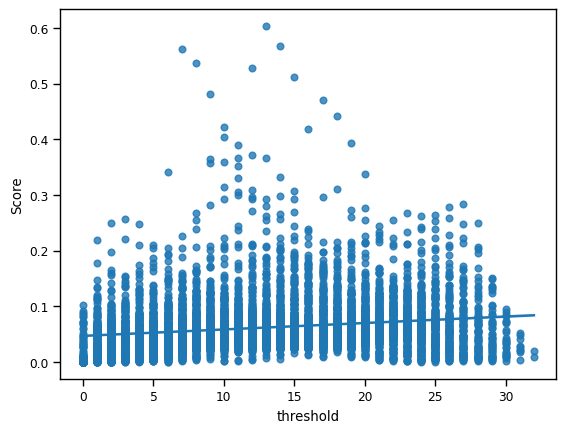

In [ ]:
sns.regplot(scores.reset_index(), x="threshold", y="Score")

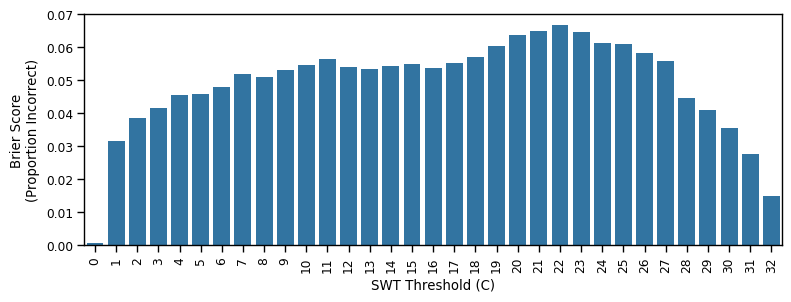

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 3))
sns.barplot(scores.groupby("threshold").median(), x="threshold", y="Score", ax=ax)
ax.set_xlabel("SWT Threshold (C)")
ax.set_ylabel("Brier Score\n(Proportion Incorrect)")
_ = plt.xticks(rotation=90)

### Interval Width

A version that's weighted towards anomaly does very poorly for 95% CI accuracy (i.e., not many observations tend to be within the CI) because uncertainty is dominated by coefficient estimation.

With noise, the median width increases to 12 C (IQR: 10.7-13.5 C; total range: 2.4-21 C), and typical capture is 97% (IQR: 97-99.9%). Fewer than 95% of values are in the estimated IQR for just 18% of sites. It is now overly conservative, presumably because this adds error (noise + uncertainty) to uncertainty, thus double-counting uncertainty.

At 50% confidence (median width 4.2 C), it's very conservative, with median 65% of observations in the 50% CI (21% of gages short of 50%).

With 2-PC, it's a little insufficiently conservative. The 50% interval (2.4 C wide) captures 37%. Calibrating it wider by 1.5 brings 95% interval capture up to 97%, and the 50% CI is spot-on at 51%.

In [ ]:
size = 0.5
widths = values.loc[:, ["id", "date"]]
widths["upper"] = values.iloc[:, 3:].apply(lambda x: np.quantile(x, (1+size)/2), axis=1)
widths["lower"] = values.iloc[:, 3:].apply(lambda x: np.quantile(x, (1-size)/2), axis=1)
widths["median"] = values.iloc[:, 3:].apply(lambda x: np.quantile(x, 0.5), axis=1)
widths["width"] = widths["upper"] - widths["lower"]

In [ ]:
widths.describe()

,date,upper,lower,median,width
count,842449,842449.000000,842449.000000,842449.000000,842449.000000
mean,2019-02-25 21:26:43.714408960,14.742979,11.183904,12.943204,3.559075
min,2015-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000
25%,2017-04-11 00:00:00,9.362836,5.919354,7.645424,2.986903
50%,2019-03-21 00:00:00,14.523304,11.145441,12.836984,3.490964
75%,2021-02-03 00:00:00,20.182446,16.429092,18.290131,4.116371
max,2022-12-31 00:00:00,34.754409,29.247766,32.087678,19.656004
std,NaN,6.958316,6.614782,6.809093,0.952060


In [ ]:
widths["obs"] = values["temperature"]
widths["isin"] = (widths["obs"] <= widths["upper"]) & (widths["obs"] >= widths["lower"])

In [ ]:
widths.groupby("id")["isin"].mean().describe()
# widths["isin"].mean()

count    320.000000
mean       0.515552
std        0.158299
min        0.090659
25%        0.401427
50%        0.519218
75%        0.639163
max        0.865024
Name: isin, dtype: float64

In [ ]:
(widths.groupby("id")["isin"].mean() < size).mean()

0.453125

### Example Plots

In [ ]:
which_sites = pd.Series(values["id"].unique()).sample(n=8)
sample = values.loc[values["id"].isin(which_sites)].melt(["id", "date", "temperature"])
sample

,id,date,temperature,variable,value
0,0208062765,2015-01-01,8.1,temp.mod_0.09_0,7.073723
1,0208062765,2015-01-02,7.8,temp.mod_0.09_0,6.779709
2,0208062765,2015-01-03,8.0,temp.mod_0.09_0,6.953590
3,0208062765,2015-01-04,8.7,temp.mod_0.09_0,7.463729
4,0208062765,2015-01-05,8.8,temp.mod_0.09_0,8.715880
...,...,...,...,...,...
27140995,12447390,2022-12-27,1.5,temp.mod_0.91_99,0.250437
27140996,12447390,2022-12-28,1.5,temp.mod_0.91_99,0.257617
27140997,12447390,2022-12-29,1.3,temp.mod_0.91_99,0.127458
27140998,12447390,2022-12-30,1.5,temp.mod_0.91_99,0.000000


Excellent! With the new (overly-conservative) version, we do see wide ranges. We also see the occasional "stray" ensemble member, as one would expect.

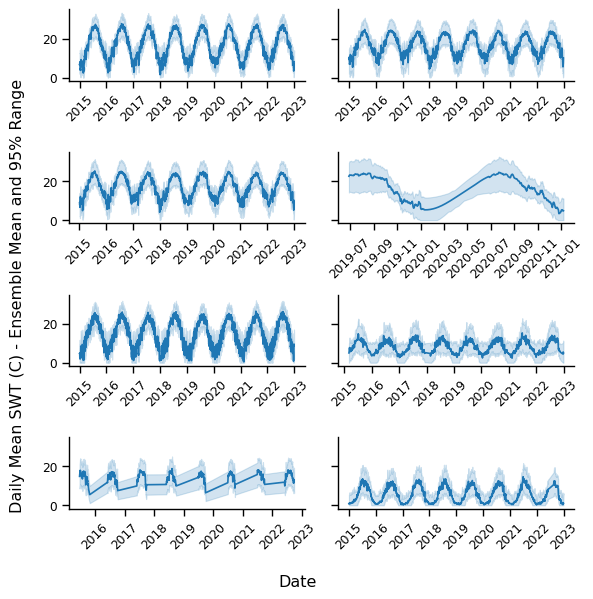

In [ ]:
g = sns.relplot(sample,
            x="date",
            y="value",
            col="id",
            col_wrap=2,
            height=1.5,
            aspect=2,
            kind="line",
            facet_kws={"sharex": False},
            errorbar='pi').tick_params(axis='x', rotation=45)
g.set_axis_labels("", "")
g.set_titles("")
g.fig.supxlabel("Date")
g.fig.supylabel("Daily Mean SWT (C) - Ensemble Mean and 95% Range")
g.tight_layout()
g.savefig("val_figures/ensemble_plots.png", dpi=1200)

# Extrapolation Tests

## Regional

For regional extrapolation, we split the CONUS into 16 grid cells (four-by-four), of which 15 actually contain gages and 14 have more than 1 gage.  Across those 14, we run a leave-one-out cross-validation, training a model on the other 13 and predicting all gages in the left-out grid cell.  This tests the ability of the model to make predictions for contiguous regions with no gages, meaning that it has no training data from nearby sites and has to go off its knowledge of general trends.

The cell 0x0 (southwesternmost) only has one gage in it, so results from that one should probably be ignored, but we'll include it.  The next fewest gages is 9, in Maine (3x3).  Some cells are, of course, considerably sparser than others, and gage count additionally varies with the size of cells on the US borders, as in the case of both 0x0 and 3x3.

<Axes: xlabel='lon', ylabel='lat'>

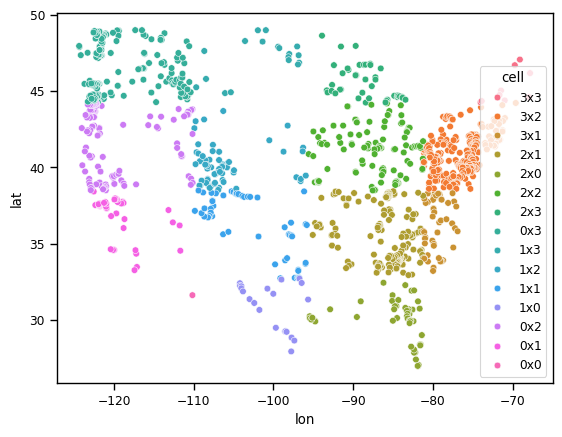

In [ ]:
N = 4
latmin = all_data["lat"].min()
latmax = all_data["lat"].max() + 1
lonmin = all_data["lon"].min()
lonmax = all_data["lon"].max() + 1
latstep = (latmax - latmin)/N
lonstep = (lonmax - lonmin)/N

all_data["lat_cell"] = ((all_data["lat"] - latmin) / latstep).astype("int")
all_data["lon_cell"] = ((all_data["lon"] - lonmin) / lonstep).astype("int")
all_data["cell"] = all_data["lon_cell"].astype("str") + "x" + all_data["lat_cell"].astype("str")
sns.scatterplot(all_data.groupby("id")[["lat", "lon", "cell"]].first(), x="lon", y="lat", hue="cell")

In [ ]:
def modbuilder(data):
    nx = NEXT.NEXT.from_data(data)
    print("New region", end="")
    def prd(x):
        print("|", end="")
        try:
            return nx.run(x, reset=True)
        except KeyboardInterrupt as e:
            raise e
        except:
            return None
    return prd
with warnings.catch_warnings(action="ignore"):
    spatxv = NEWT.analysis.kfold(all_data, modbuilder, by='cell', k=1, output = bp + f"results/SpatialXV{coef_variant}.csv", redo=rerun)

New region||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||New region||||||||||||||||||||||||||||||||||||||||New region||||||||||||||||||New region|||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||New region||||||||||||||||||||||||||||||||||||||||||||New region|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [ ]:
with warnings.catch_warnings(action="ignore"):
    spatperf = spatxv.groupby(["id", "cell"]).apply(NEWT.analysis.perf_summary)

Globally, there is a negligible penalty, with RMSE at 2.3 C and R2 at 0.93.

With 2-PC, the penalty is the same, with RMSE of 2.2 C.

In [ ]:
spatperf.describe()

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000,1248.000000
mean,0.893698,2.454981,0.257810,0.976907,0.914290,0.299477,3.320288,0.289685,2.548915
std,0.127849,1.176028,6.746634,0.018095,0.069481,0.918179,14.795763,1.526521,1.895392
min,0.003043,1.144872,-188.434862,0.824755,0.175511,-16.864939,-75.168295,-20.095198,0.164124
25%,0.883831,1.852079,0.784070,0.969973,0.900802,0.235782,-2.851074,-0.368187,1.173637
50%,0.933753,2.205681,0.890584,0.980499,0.928942,0.554090,2.401686,0.313579,2.100251
75%,0.955677,2.712173,0.930627,0.988913,0.949556,0.676484,7.635074,1.004678,3.475104
max,0.981986,20.942604,0.977666,0.999155,0.996135,0.828155,169.802333,7.023316,18.392015


In [ ]:
spatperf.groupby("cell")["RMSE"].median()

cell
0x0    3.355196
0x1    2.725808
0x2    2.531515
0x3    2.250656
1x0    2.345042
1x1    2.429507
1x2    2.346555
1x3    2.794028
2x0    2.128978
2x1    2.114333
2x2    2.029658
2x3    2.301174
3x1    2.174800
3x2    2.079393
3x3    2.918221
Name: RMSE, dtype: float64

Performance does vary somewhat with region, but all have a median RMSE of 2.0-3.0 C except the one-gage one.

(0.0, 10.0)

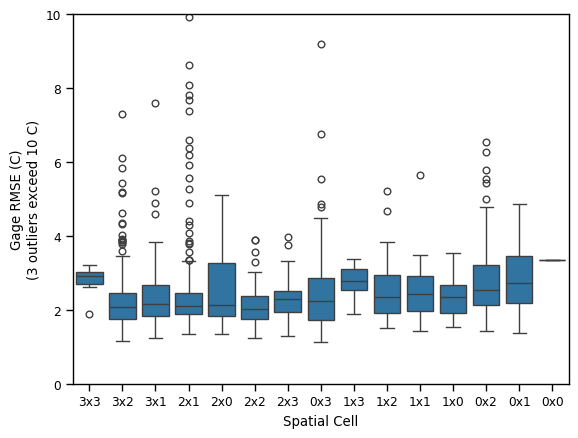

In [ ]:
ax = sns.boxplot(spatperf, x="cell", y="RMSE")
ax.set_xlabel("Spatial Cell")
ax.set_ylabel("Gage RMSE (C)\n(3 outliers exceed 10 C)")
ax.set_ylim(0, 10)

## Elevation

For elevation extrapolation, we train on the lower 95% and test on the upper 5%.  We also just plot errors by elevation.

### Non-Extrapolating

To look at bias, remove the `.abs()`.  There is no trend in bias and a modest trend in absolute error (about 2 -> 2.6 C in the combined cross-validation and test sets).  However, this seems to be because median errors are very high in the 2000-2500 m range; otherwise, there's no obvious trend.  With that group removed, the trend is present but weaker.

In [ ]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
cols = ["id", "elev_min", "date", "temp.mod", "temperature"]
preds = pd.concat([preds[cols], kfr[cols]])

In [ ]:
preds["error"] = (preds["temp.mod"] - preds["temperature"]).abs()
elev_perf = preds.groupby("id")[["elev_min", "error"]].mean()

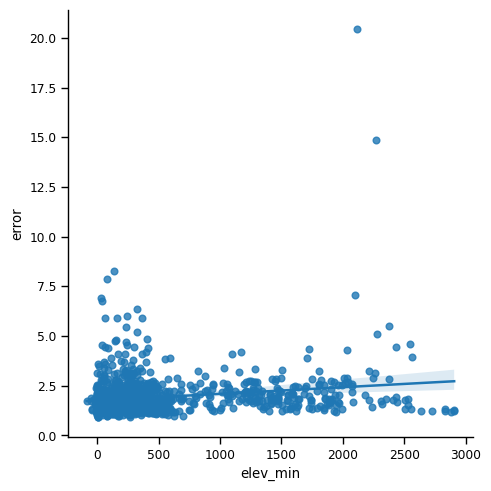

In [ ]:
sns.lmplot(elev_perf, x="elev_min", y="error")

In [ ]:
elev_perf.assign(elev_bucket = lambda x: x["elev_min"] // 500).groupby("elev_bucket").median()

,elev_min,error
elev_bucket,,
-1.0,-0.904104,1.423060
0.0,183.398407,1.645706
1.0,622.275818,1.805039
2.0,1272.117493,2.039758
3.0,1747.874878,1.824767
4.0,2225.939331,2.673124
5.0,2596.154053,1.326607


### Extrapolating

In [ ]:
all_data["elev_min"].quantile(0.95)

1804.63671875

In [ ]:
train = all_data[all_data["elev_min"] < 1800]
test = all_data[all_data["elev_min"] >= 1800].dropna()

In [ ]:
len(test["id"].unique())

73

In [147]:
def predict(model, ws):
    print("|", end="")
    try:
        return model.run(ws, reset=True)
    except ValueError:
        return None

with warnings.catch_warnings(action="ignore"):
    model = NEXT.NEXT.from_data(train)
    prd = test.groupby("id").apply(lambda x: predict(model, x), include_groups=False).reset_index().drop(columns="level_1")

|||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

Extrapolating to high elevation increases median RMSE to 2.8 C (+0.6), which is a much lower penalty than TempEst 2 (+1.1).  Also, bias is much less, but R2 is penalized more.

So... using canopy density instead of forest LC, it suddenly does way better for the very highest elevations (RMSE 3-4 C, weaker trend).  Could the issue be (in large part) either that "forest" over 3000 m is often "patchy trees", or that said "patchy trees" weren't being counted as "forest"?

Bafflingly, 2-PC dramatically reduces the penalty, with an RMSE of just 2.5 C (+0.4), and the highest-elevation sites have RMSE < 3 C. But now for some reason I'm getting an RMSE of 2.8 C again. What changed? Also NSE is still high, which is weird.

Well, one thing that's happening is a marked tendency to completely miss the peaks - like, not even close. It may be that the high NSE/high RMSE pairs are occurring for sites with very high variation, which mutes the impact of RMSE on NSE. Adding the full suite of weighted PCs does a spectacularly awful job, though error isn't much worse. (With the peaks, it seems like it's hugely underestimating some combination of Amplitude and SpringSummer.)

Okay, I am *so* confused now. Going back to the original PC suite (albeit with date fixing) gets RMSE down to 2.5 C, but NSE is *lower*, but the plots look better???

Aaaand... now with the original PC suite, the RMSE is up to 2.9 C. Is this just random?

Two-PC/fixed dates gets us back to 2.5 C, but still with a large MaxMiss of 4.2 C.

In [148]:
with warnings.catch_warnings(action="ignore"):
    perf = prd.groupby(["id", "lat", "lon", "elev_min"]).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index().drop(columns="level_4")
perf.describe()

,lat,lon,elev_min,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000
mean,40.776704,-109.867806,2166.425646,0.833056,3.224144,-3.448194,0.964666,0.886596,0.149295,-10.923975,-1.568130,4.419274
std,2.618790,3.935740,311.234666,0.136053,3.061136,30.197100,0.021464,0.124374,1.385541,24.615505,3.531947,3.322122
min,35.777114,-120.237979,1801.255615,0.052674,1.488099,-256.549470,0.911176,0.175511,-11.458878,-76.551000,-21.778358,0.795675
25%,38.919908,-110.871600,1905.447998,0.797011,2.099512,0.368914,0.951346,0.868571,0.199999,-24.822373,-2.271823,2.191611
50%,40.108596,-108.297588,2071.349121,0.864155,2.468097,0.724502,0.971764,0.909121,0.332021,-9.475902,-0.877933,4.209149
75%,43.458361,-106.940958,2378.006348,0.900628,3.075125,0.825248,0.982201,0.942254,0.406537,1.089103,0.074972,5.469615
max,45.617967,-105.584139,2905.092529,0.954903,22.526537,0.926228,0.994626,0.985451,0.615609,66.464112,2.376209,20.521983


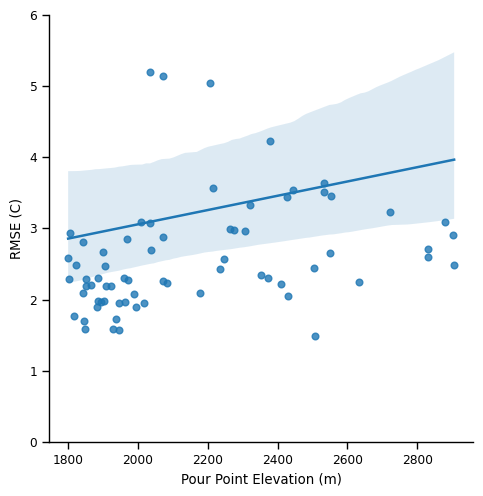

In [149]:
ax = sns.lmplot(perf, x="elev_min", y="RMSE")
ax.set_axis_labels("Pour Point Elevation (m)", "RMSE (C)")
ax.set(ylim=(0, 6))

In [150]:
counts = prd.groupby("id", as_index=False)["date"].count()
eligible = perf[(perf["id"].isin(counts[(counts["date"] >= 365*3)]["id"])) &
               (perf["elev_min"] >= 2400)].sort_values("NSE")
best = eligible[eligible["RMSE"] < 4].iloc[-2:]["id"]  # want to make sure it's low absolute error, too
worst = eligible.iloc[:2]["id"]
rand = eligible[-(eligible["id"].isin(pd.concat([best, worst])))].sample(n=4)["id"]
ids = [list(best), list(rand)[:2], list(rand)[2:], list(worst)]
labels = ["Best", "Random", "Random", "Worst"]

Text(0.02, 0.5, 'Daily Mean Stream Temperature (C)')

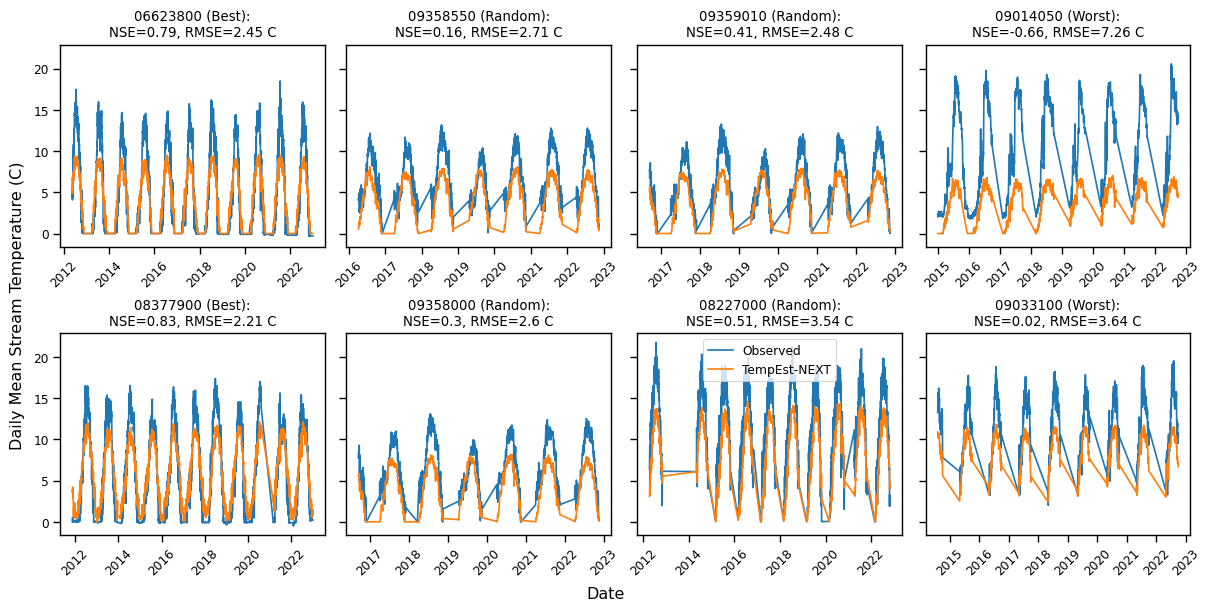

In [151]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), layout="compressed", sharex=False, sharey=True)
for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        which = ids[j][i]
        prow = eligible[eligible["id"] == which].iloc[0].to_dict()
        site = prd[prd["id"] == which].sort_values("date")
        title = f"{prow['id']} ({labels[j]}):\nNSE={round(prow['NSE'], 2)}, RMSE={round(prow['RMSE'], 2)} C"
        ax.plot(site["date"], site["temperature"], label="Observed")
        ax.plot(site["date"], site["temp.mod"], label="TempEst-NEXT")
        ax.set_title(title)
        ax.tick_params(axis='x', labelrotation=45)
        if i==1 and j==2:  # hand-selected, retune as needed
            ax.legend(loc="upper center")
fig.supxlabel("Date")
fig.supylabel("Daily Mean Stream Temperature (C)")

In [152]:
def get_ssn(day, temps):
    data = pd.DataFrame({"day": day, "temperature": temps})
    try:
        return ThreeSine.from_data(data, warn=False).to_df()
    except:
        return None  # failed fit
ssn_obs = prd.groupby("id").apply(lambda x: get_ssn(x["day"], x["temperature"]), include_groups=False)
ssn_mod = prd.groupby("id").apply(lambda x: get_ssn(x["day"], x["temp.mod"]), include_groups=False).rename(columns=lambda x: x + "_mod")

In [153]:
ssn_obs.describe()

,Intercept,Amplitude,FallDay,WinterDay,SpringDay,SummerDay,SpringSummer,FallWinter,R2,RMSE
count,71.000000,71.000000,71.000000,71.00000,71.000000,71.000000,71.000000,71.000000,0.0,71.000000
mean,7.336799,7.496188,314.436620,65.21831,148.492958,217.084507,1.766894,1.476384,NaN,0.699586
std,3.924154,2.235039,13.675559,30.12625,11.915024,16.784982,1.062310,0.768891,NaN,0.216115
min,3.138215,0.182583,300.000000,11.00000,120.000000,200.000000,-0.457089,-0.171838,NaN,0.066742
25%,5.135121,5.961319,301.000000,29.00000,142.000000,201.000000,1.020870,0.863172,NaN,0.568907
50%,6.914991,7.374278,313.000000,80.00000,152.000000,213.000000,1.695453,1.565412,NaN,0.676151
75%,8.204409,9.005279,322.000000,88.00000,155.000000,237.000000,2.501272,1.965230,NaN,0.819809
max,30.100749,12.179893,358.000000,110.00000,176.000000,240.000000,4.765209,3.488701,NaN,1.139397


In [154]:
ssn_mod.describe()

,Intercept_mod,Amplitude_mod,FallDay_mod,WinterDay_mod,SpringDay_mod,SummerDay_mod,SpringSummer_mod,FallWinter_mod,R2_mod,RMSE_mod
count,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,71.000000,0.0,71.000000
mean,6.004981,6.809552,336.183099,62.197183,122.676056,211.845070,0.173451,0.472798,NaN,0.127284
std,1.881849,1.648714,22.381951,21.493933,4.732184,8.242135,0.153876,0.389665,NaN,0.049534
min,1.873562,2.377186,300.000000,27.000000,120.000000,200.000000,-0.002523,-0.965331,NaN,0.037703
25%,4.884240,5.718750,321.500000,55.000000,120.000000,208.000000,0.081162,0.186658,NaN,0.095241
50%,5.941485,6.902974,339.000000,65.000000,120.000000,210.000000,0.120887,0.534428,NaN,0.120822
75%,7.382068,7.977304,359.500000,80.000000,124.000000,211.000000,0.233168,0.671285,NaN,0.158368
max,9.286785,10.766706,363.000000,93.000000,137.000000,240.000000,0.715197,1.508072,NaN,0.256035


## Walk-Forward

For walk-forward validation, we train a model on all sites up to a given year, then predict the next five year.  This is done for all prediction years from 2010-2022, allowing ten years of initial training data.  We predict five years at a time to provide sufficient coefficient estimation data, since it's running in ungaged mode.

RMSE goes up to 2.3 C again (2.2 C for 2-PC), with little penalty to R2 or bias.  So spatial and temporal extrapolation seem to have similar effects.

In [155]:
all_data["year"] = all_data["date"].dt.year
years = list(range(2010, 2023, 5))
file = bp + f"results/WalkForward{coef_variant}.csv"
def runmod(mod, data):
    # Try/catch because some single-year snapshots don't have enough data.
    # This shouldn't happen for prediction use, but as implemented for testing,
    # missing ST obs = missing data, since the rows get dropped.
    try:
        return mod.run(data, reset=True, use_climate=False)
    except:
        return None
def runner(year):
    print(year)
    model = NEXT.NEXT.from_data(all_data[all_data["year"] < year])
    inp = all_data[(all_data["year"] >= year) & (all_data["year"] < year + 5)]
    return inp.groupby("id").apply(lambda x: runmod(model, x), include_groups=False)
if not rerun and os.path.exists(file):
    wfv = pd.read_csv(file, dtype={"id": "str"}, parse_dates=["date"])
    wfv["id"] = wfv.index
else:
    with warnings.catch_warnings(action="ignore"):
        wfv = pd.concat([runner(year) for year in years])
    wfv.to_csv(file, index_label="id")

In [156]:
with warnings.catch_warnings(action="ignore"):
    perf = wfv.groupby("id").apply(NEWT.analysis.perf_summary)

In [157]:
perf.describe()

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
count,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1245.000000,1247.000000,1247.000000,1247.000000
mean,0.880005,2.443427,0.331900,0.976982,0.914721,0.117920,2.776842,0.177288,2.580389
std,0.130939,1.048875,6.146775,0.018100,0.069938,0.954688,13.852916,1.325875,1.769016
min,0.001874,1.140119,-156.980296,0.824755,0.153348,-17.679736,-58.116104,-17.430816,0.167628
25%,0.866385,1.878173,0.784413,0.970384,0.901605,0.021295,-2.966886,-0.390813,1.245352
50%,0.920943,2.201147,0.887910,0.980460,0.929638,0.358616,1.363121,0.178017,2.191053
75%,0.946924,2.671406,0.928044,0.988958,0.949889,0.532357,5.612897,0.741926,3.445549
max,0.977098,18.385704,0.974357,0.999155,1.000000,0.833357,170.677098,6.208470,16.517402


In [158]:
with warnings.catch_warnings(action="ignore"):
    perf_byyr = wfv.groupby(["id", "year"]).apply(NEWT.analysis.perf_summary).groupby("year").median()

The first prediction years are 2010, 2015, and 2020.  These aren't distinctly low-error years, nor are the last (2014, 2019, 2022) consistently high-error.  So it doesn't seem to have any problem with extrapolating forward, in terms of RMSE.  We also don't see a trend in bias.

Text(0, 0.5, 'Median RMSE (C)')

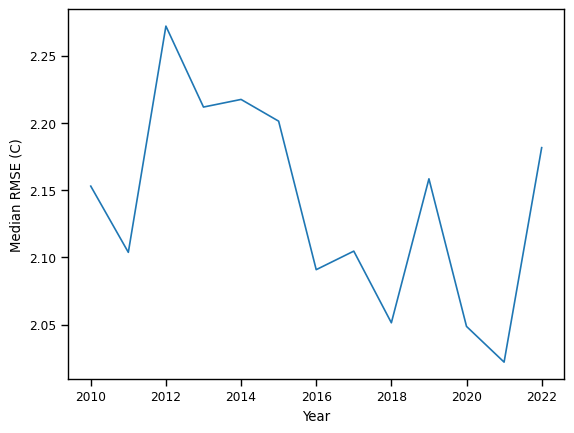

In [159]:
ax = sns.lineplot(perf_byyr, x=perf_byyr.index, y="RMSE")
ax.set_xlabel("Year")
ax.set_ylabel("Median RMSE (C)")

Text(0, 0.5, 'Median RMSE (C)')

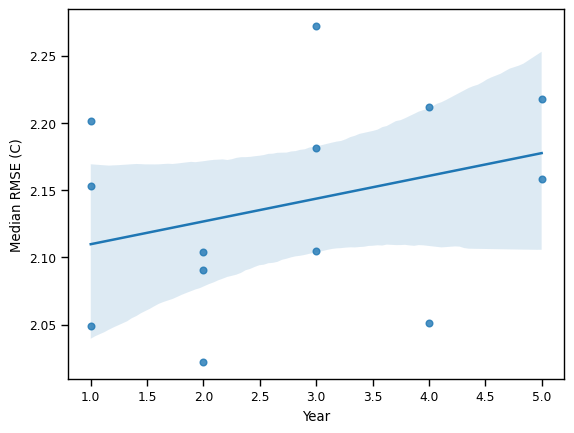

In [160]:
perf_byyr["pyr"] = list(range(1, 6))*2 + [1,2,3]
ax = sns.regplot(perf_byyr, x="pyr", y="RMSE")
ax.set_xlabel("Year")
ax.set_ylabel("Median RMSE (C)")

In [161]:
scipy.stats.pearsonr(perf_byyr["pyr"], perf_byyr["RMSE"])

PearsonRResult(statistic=0.3163479135480668, pvalue=0.2923250345982434)

## Regime Shift/Disturbance

# Small Stream

# True Forecast

For forecast testing, we run a 16-day forecast using HRRR and GFS (HRRR for day 1-2, GFS after that).  We also use HRRR to fill in "last week" for anomaly smoothing.  Then, we come back in a few weeks and check the performance.  Performance testing should use RMSE and bias only, since trend metrics (R2, NSE) will have minimal observed variance to work with.  Performance should be analyzed aggregated by lead time.  For the 2-day lead (tomorrow's mean), we should expect the RMSE to converge on about 2.4 C.

Since this is an ungaged model, and the only ungaged forecasting model, there is no reference performance to use for computing a skill score.  Instead, the question is whether the error is sufficiently low as to be useful.

## Shape Retrieval

As of this writing, the NLDI service is down, so we're going to use cached shapefiles.  This is (hopefully) temporary and should be changed to use regular retrieval functions.

## Run Forecast

## Verify Forecasts

In [162]:
fcp = bp + "forecasts/"
def parse_fc(fn):
    rundate = np.datetime64(fn.split(".")[0])
    fcdat = pd.read_csv(fcp + fn, parse_dates=["date"], dtype={"id": "str"})
    fcdat = fcdat.loc[fcdat["date"] >= rundate, :]
    fcdat["rundate"] = rundate
    fcdat["lead"] = ((fcdat["date"] - rundate + np.timedelta64(1, 'D'))/np.timedelta64(1, 'D')).astype(int)  # +1: today's mean is a 1-day lead.
    return fcdat
forecast = pd.concat([parse_fc(fn) for fn in os.listdir(fcp)])
forecast = forecast.loc[forecast["lead"] < 17]  # 17-day shouldn't be in there

In [163]:
sites = list(forecast["id"].unique())
# Run from first forecast date.
obs = nwis.get_dv(sites=sites, start="2025-02-07", end="2030-01-01", parameterCd="00010")[
    0].reset_index()[["site_no", "datetime", "00010_Mean"]].rename(
        columns={"00010_Mean": "temperature", "site_no": "id", "datetime": "date"}
    ).dropna().assign(date=lambda x: x["date"].dt.normalize().dt.tz_localize(None))
obs = obs[obs["temperature"] > -1]

In [164]:
merged = forecast.merge(obs, on=["id", "date"], how="left").dropna()
with warnings.catch_warnings(action="ignore"):
    perf = merged.groupby(["id", "lead"]).apply(NEWT.analysis.perf_summary, include_groups=False)
perf[["RMSE", "Bias"]].describe()

,RMSE,Bias
count,3759.000000,3759.000000
mean,2.194004,-0.042400
std,0.947074,1.483006
min,0.405771,-7.540866
25%,1.503685,-0.823922
50%,2.168813,-0.060266
75%,2.687412,0.865645
max,7.861555,5.391259


In [165]:
meds = perf.groupby("lead")[["RMSE", "Bias"]].median()
meds

,RMSE,Bias
lead,,
1,2.090253,-0.014849
2,2.156401,0.025568
3,2.260161,-0.026374
4,2.343459,-0.032107
5,2.264283,-0.060266
6,2.268421,-0.144178
7,2.234301,-0.145756
8,2.273383,-0.040232
9,2.261322,-0.033316


In [166]:
bylead = merged.groupby("lead").apply(NEWT.analysis.perf_summary, include_groups=False)
bylead

,,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
lead,,,,,,,,,,
1,0,0.818761,2.357540,0.814666,-0.621772,0.268234,0.781066,-0.748402,-0.062334,2.699563
2,0,0.812986,2.394229,0.808616,-0.633486,0.261961,0.779753,-0.903516,-0.075072,2.109205
3,0,0.807509,2.451418,0.802340,-0.641929,0.261318,0.778288,-1.078429,-0.090230,2.549035
4,0,0.805131,2.466426,0.800112,-0.630899,0.269577,0.774942,-0.883234,-0.073848,2.770107
5,0,0.809417,2.441761,0.803636,-0.633039,0.267294,0.778394,-1.144336,-0.096206,2.709205
6,0,0.815665,2.424837,0.808533,-0.630802,0.270699,0.782166,-1.913157,-0.163916,1.849035
7,0,0.816698,2.388191,0.810917,-0.638423,0.268150,0.782555,-1.543880,-0.132193,2.549035
8,0,0.809744,2.362986,0.806560,-0.660356,0.257022,0.780048,-0.309391,-0.026024,2.709205
9,0,0.802545,2.376004,0.800256,-0.691375,0.242104,0.779026,0.074590,0.006250,2.649035


In [167]:
round(meds.reset_index().merge(bylead, on="lead", suffixes=["_median", "_global"])[["lead", "RMSE_median", "RMSE_global", "Bias_median", "Bias_global"]
                                                                                  ].rename(
    columns={"lead": "Lead Time (days)",
             "RMSE_median": "Median RMSE (C)",
             "RMSE_global": "Global RMSE (C)",
             "Bias_median": "Median Bias (C)",
             "Bias_global": "Global Bias (C)"}), 1)

,Lead Time (days),Median RMSE (C),Global RMSE (C),Median Bias (C),Global Bias (C)
0,1,2.1,2.4,-0.0,-0.1
1,2,2.2,2.4,0.0,-0.1
2,3,2.3,2.5,-0.0,-0.1
3,4,2.3,2.5,-0.0,-0.1
4,5,2.3,2.4,-0.1,-0.1
5,6,2.3,2.4,-0.1,-0.2
6,7,2.2,2.4,-0.1,-0.1
7,8,2.3,2.4,-0.0,-0.0
8,9,2.3,2.4,-0.0,0.0
9,10,2.3,2.4,-0.0,-0.0


In [168]:
NEWT.analysis.perf_summary(merged)

,R2,RMSE,NSE,StationaryNSE,ClimatologyNSE,AnomalyNSE,Pbias,Bias,MaxMiss
0,0.80293,2.369159,0.800708,0.835334,0.238343,0.777345,-0.943447,-0.079898,2.649035


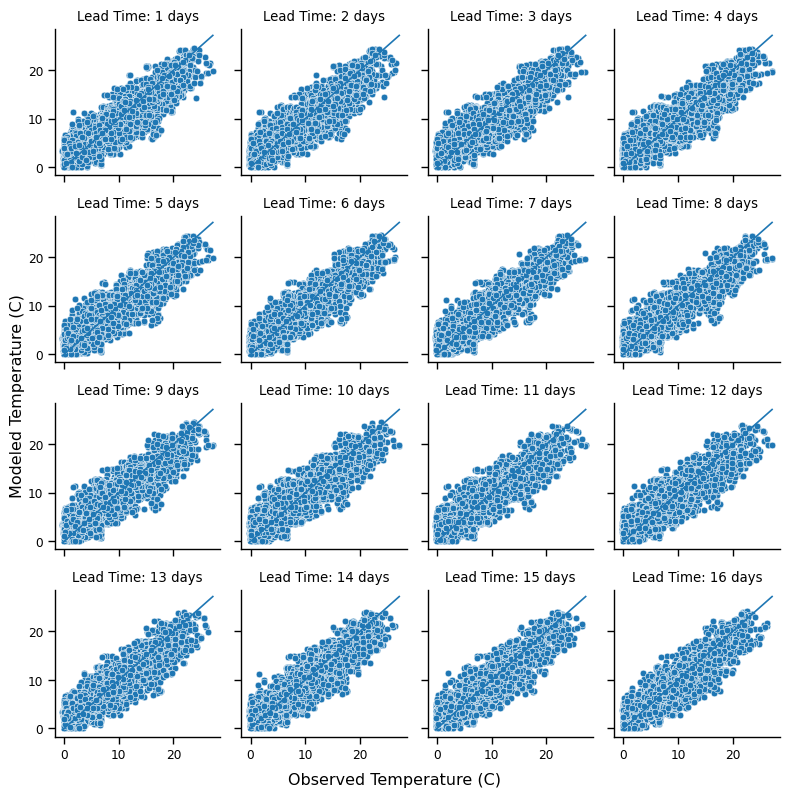

In [169]:
# ax = merged.plot.scatter(x="temp.mod", y="temperature")
pmerged = merged.merge(bylead.round(2), on="lead", how="left")
minmax = [merged["temperature"].min(), merged["temperature"].max()]
minmax = pd.DataFrame({"x": minmax, "y": minmax})
# pmerged["lead"] = pmerged["lead"].astype(str) + " (RMSE: " + pmerged["RMSE"].astype(str) + " C)"
# fig, ax = plt.subplots(1, 1, figsize=(5, 5), layout="compressed")
# sns.scatterplot(pmerged, x="temperature", y="temp.mod", hue="lead", ax=ax)
fig = sns.relplot(pmerged, x="temperature", y="temp.mod", col="lead", col_wrap=4,
                   height=2, aspect=1, kind="scatter")
for ax in fig.axes:
    sns.lineplot(minmax, x="x", y="y", ax=ax)
fig.figure.supxlabel("Observed Temperature (C)")
fig.set_xlabels("")
fig.figure.supylabel("Modeled Temperature (C)")
fig.set_ylabels("")
fig.set_titles(col_template="Lead Time: {col_name} days")
# ax.plot(pmerged["temperature"], pmerged["temperature"], label="1:1")
# ax.set_ylabel("Modeled Temperature (C)")
# ax.set_xlabel("Observed Temperature (C)")
# ax.legend().set_title("Lead Time (days)")
plt.savefig("val_figures/forecast.png", dpi=1000)

## National Plots

In [170]:
states = gpd.read_file("usa_states/cb_2018_us_state_20m.shp")
states = states[-states["STUSPS"].isin(["AK", "HI", "PR"])]

In [171]:
coords = test_data_hrrr.groupby("id")[["lat", "lon"]].agg("first")
bestworst = (perf.groupby("id").
             apply(lambda x: pd.DataFrame({"best": x["RMSE"].min(), "worst": x["RMSE"].max()}, index=[0]),
                   include_groups=False).
             merge(coords, on="id", how="left"))

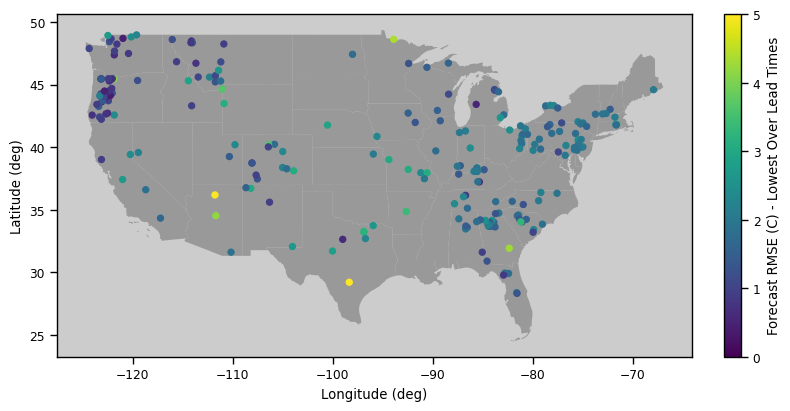

In [172]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#CCC")
states.plot(ax=ax, color="#999")
bestworst.plot.scatter(x="lon", y="lat", c="best", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Forecast RMSE (C) - Lowest Over Lead Times")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_forecast_best.png", dpi=1000)

In [173]:
bestworst.describe()

,best,worst,lat,lon
count,235.000000,235.000000,235.000000,235.000000
mean,1.789332,2.538942,39.993605,-95.807835
std,0.845724,1.000808,4.909462,17.421542
min,0.405771,0.565724,28.332787,-124.357089
25%,1.232821,1.776958,35.710487,-112.053250
50%,1.753864,2.564537,40.229547,-87.398908
75%,2.140487,3.036876,43.720817,-81.484683
max,7.276658,7.861555,48.984601,-67.935278


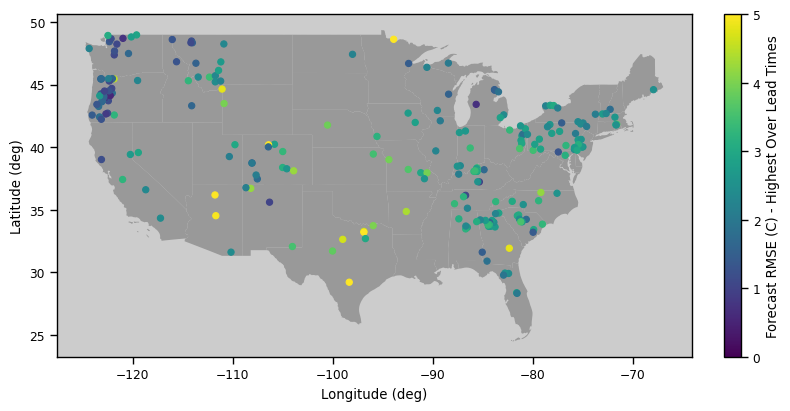

In [174]:
fig = plt.figure(figsize=(8, 4), layout="compressed")
ax = plt.axes(facecolor="#CCC")
states.plot(ax=ax, color="#999")
bestworst.plot.scatter(x="lon", y="lat", c="worst", ax=ax, colormap="viridis", vmin=0, vmax=5)
cb = ax.collections[1].colorbar
cb.set_label("Forecast RMSE (C) - Highest Over Lead Times")
ax.set_xlabel("Longitude (deg)")
ax.set_ylabel("Latitude (deg)")
plt.savefig("val_figures/conus_forecast_worst.png", dpi=1000)

# Error Correlations

In [175]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
gcols = ["id", "elev_min", "elev", "lat", "lon", "area", 'water', 'developed', 'barren', 'forest', 'shrubland', 'herbaceous',
       'cultivated', 'wetland', 'ice_snow', "slope", "flowdir"]
ycols = ["date", "temp.mod", "temperature"]
cols = gcols + ycols
preds = pd.concat([preds[cols], kfr[cols]])

In [176]:
x = np.arange(10)
y = np.arange(10, 0, -1)
x[x<y] = y[x<y]
x

array([10,  9,  8,  7,  6,  5,  6,  7,  8,  9])

In [177]:
with warnings.catch_warnings(action="ignore"):
    perf = preds.groupby(gcols).apply(NEWT.analysis.perf_summary, include_groups=False).reset_index()

In [178]:
hap = perf[perf["area"] > 3e10]

Look list (R>0.1 across pbias, R2, or NSE):

- Water: effects negligible, it's noise because of few sites >5%.
- Slope: there is definitely some performance penalty to steep watersheds, but minimal.
- Latitude: is just because the warm Southeastern sites do well.
- Shrubland: definitely correlates with bias, but weakly (R2 0.01).
- Longitude: Western sites have a bit worse R2, which isn't news.
- Forest: does correlate with some penalty to R2 (R2 0.04, p~0).
- Cultivated: just noise from the few sites >20%.
- Developed: same.
- Barren: there's a real penalty to R2, but weak.
- Wetland: nothing there.

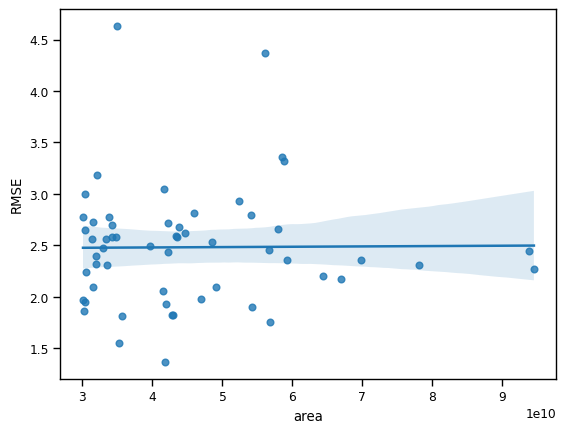

In [179]:
sel = perf[perf["area"] > 3e10]
ax = sns.regplot(sel, x="area", y="RMSE")
# ax.set_xlim(4e10, 10e10)
# ax.set_ylim(0, 1)

In [180]:
scipy.stats.pearsonr(sel["area"], sel["Pbias"])

PearsonRResult(statistic=-0.07626555027489558, pvalue=0.5763926971654847)

In [181]:
perf[gcols[1:]].agg(lambda x: scipy.stats.pearsonr(x, perf["NSE"]).statistic).abs().sort_values(ascending=False)

water         0.100632
elev_min      0.088133
lon           0.079192
elev          0.070836
barren        0.065633
forest        0.053815
developed     0.045371
cultivated    0.044511
wetland       0.040277
shrubland     0.037360
area          0.026469
herbaceous    0.022722
slope         0.011799
lat           0.009179
ice_snow      0.002664
flowdir       0.000716
dtype: float64

# Misc Plots

In [182]:
preds = pd.read_csv(bp + f"results/TestSet_hindcast{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
# kfr = pd.read_csv(bp + f"results/kfold_pca{coef_variant}.csv", dtype={"id": "str"}, parse_dates=["date"])
cols = ["id", "date", "temp.mod", "temperature"]
# preds = pd.concat([preds[cols], kfr[cols]])
# preds = pd.read_csv(bp + "TE2Xval.csv", dtype={"id": "str"}, parse_dates=["date"])[cols]
# preds = preds.loc[preds["temperature"] < 35, :]  # for direct comparison to USGS dataset
perf = preds.groupby("id").apply(NEWT.analysis.perf_summary, include_groups=False)

## 1:1 Plot with Stats

## Sitewise R2 CDF

## Temperature Density

## Sim/Obs Sample

In [183]:
counts = preds.groupby("id", as_index=False)["date"].count()
eligible = perf.reset_index()[perf.unstack().index.isin(counts[(counts["date"] >= 365*3)]["id"])].sort_values("R2")
best = eligible[eligible["RMSE"] < 1.8].iloc[-2:]["id"]  # want to make sure it's low absolute error, too
worst = eligible.iloc[:2]["id"]
rand = eligible[-(eligible["id"].isin(pd.concat([best, worst])))].sample(n=4)["id"]
ids = [list(best), list(rand)[:2], list(rand)[2:], list(worst)]
labels = ["Best", "Random", "Random", "Worst"]

In [184]:
eligible.iloc[0].to_dict()

{'id': '02334430',
 'level_1': 0,
 'R2': 0.04324022821406693,
 'RMSE': 7.772686947147586,
 'NSE': -24.247927010224902,
 'StationaryNSE': 0.9788396728160809,
 'ClimatologyNSE': 0.6440955568663603,
 'AnomalyNSE': -2.493222804471739,
 'Pbias': 52.70930636816025,
 'Bias': 5.71836159544671,
 'MaxMiss': 11.128890526064888}

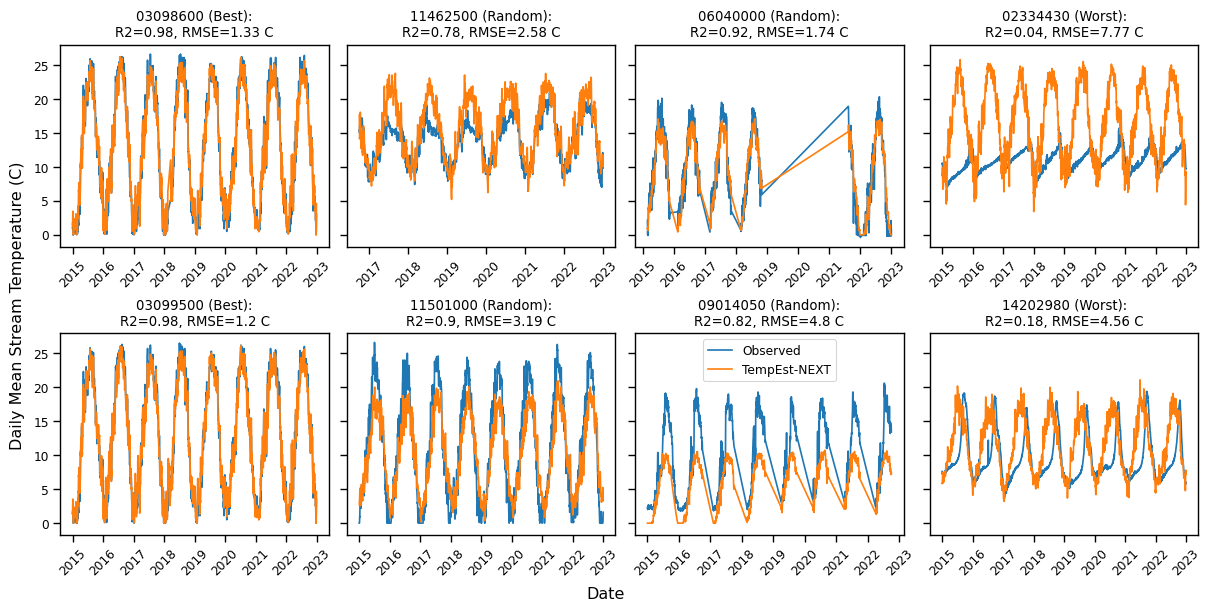

In [185]:
fig, axes = plt.subplots(2, 4, figsize=(12, 6), layout="compressed", sharex=False, sharey=True)
for i in range(2):
    for j in range(4):
        ax = axes[i, j]
        which = ids[j][i]
        prow = eligible[eligible["id"] == which].iloc[0].to_dict()
        site = preds[preds["id"] == which].sort_values("date")
        title = f"{prow['id']} ({labels[j]}):\nR2={round(prow['R2'], 2)}, RMSE={round(prow['RMSE'], 2)} C"
        ax.plot(site["date"], site["temperature"], label="Observed")
        ax.plot(site["date"], site["temp.mod"], label="TempEst-NEXT")
        ax.set_title(title)
        ax.tick_params(axis='x', labelrotation=45)
        if i==1 and j==2:  # hand-selected, retune as needed
            ax.legend(loc="upper center")
fig.supxlabel("Date")
fig.supylabel("Daily Mean Stream Temperature (C)")
plt.savefig("val_figures/comparison_sample.png", dpi=1000)